## Import Libraries

In [1]:
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

2024-06-01 17:19:44.052722: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 17:19:44.052844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 17:19:44.179759: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Preprocessing

In [2]:
# Generate data paths with labels
data_dir = '/kaggle/input/data-sec-vers-2/Dataset_3'
filepaths = []
labels = []

# Path to folders
folds = os.listdir(data_dir)

# join path to folder and then path to each file, fyuhh
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

df = pd.concat([Fseries, Lseries], axis= 1)
df
# train_df = train_df[train_df['labels'] != "squamous cell carcinoma"]

,filepaths,labels
0,/kaggle/input/data-sec-vers-2/Dataset_3/normal...,normal skin
1,/kaggle/input/data-sec-vers-2/Dataset_3/normal...,normal skin
2,/kaggle/input/data-sec-vers-2/Dataset_3/normal...,normal skin
3,/kaggle/input/data-sec-vers-2/Dataset_3/normal...,normal skin
4,/kaggle/input/data-sec-vers-2/Dataset_3/normal...,normal skin
...,...,...
2958,/kaggle/input/data-sec-vers-2/Dataset_3/nevus/...,nevus
2959,/kaggle/input/data-sec-vers-2/Dataset_3/nevus/...,nevus
2960,/kaggle/input/data-sec-vers-2/Dataset_3/nevus/...,nevus
2961,/kaggle/input/data-sec-vers-2/Dataset_3/nevus/...,nevus


In [3]:
unique_labels = df['labels'].unique()
print("Unique Labels: ", unique_labels)
# ['normal skin' 'melanoma' 'vascular lesion' 'actinic keratosis'
#  'squamous cell carcinoma' 'benign keratosis' 'basal cell carcinoma'
#  'dermatofibroma' 'nevus']

desired_labels = ['normal skin', 'melanoma', 'vascular lesion', 'dermatofibroma', 'benign keratosis', 'basal cell carcinoma', 'actinic keratosis']

# Sampling 200 baris untuk setiap label
df2_list = []
# for label in unique_labels:
for label in desired_labels:
    label_df = df[df['labels'] == label]
    sampled_label_df = label_df.sample(n = 200, random_state=42)
    df2_list.append(sampled_label_df)

df2 = pd.concat(df2_list)
print(df2.labels.value_counts())
display(df2, df2.duplicated().sum())

Unique Labels:  ['normal skin' 'melanoma' 'vascular lesion' 'actinic keratosis'
 'squamous cell carcinoma' 'benign keratosis' 'basal cell carcinoma'
 'dermatofibroma' 'nevus']
labels
normal skin             200
melanoma                200
vascular lesion         200
dermatofibroma          200
benign keratosis        200
basal cell carcinoma    200
actinic keratosis       200
Name: count, dtype: int64


,filepaths,labels
180,/kaggle/input/data-sec-vers-2/Dataset_3/normal...,normal skin
154,/kaggle/input/data-sec-vers-2/Dataset_3/normal...,normal skin
111,/kaggle/input/data-sec-vers-2/Dataset_3/normal...,normal skin
247,/kaggle/input/data-sec-vers-2/Dataset_3/normal...,normal skin
60,/kaggle/input/data-sec-vers-2/Dataset_3/normal...,normal skin
...,...,...
1195,/kaggle/input/data-sec-vers-2/Dataset_3/actini...,actinic keratosis
1292,/kaggle/input/data-sec-vers-2/Dataset_3/actini...,actinic keratosis
1273,/kaggle/input/data-sec-vers-2/Dataset_3/actini...,actinic keratosis
1294,/kaggle/input/data-sec-vers-2/Dataset_3/actini...,actinic keratosis


0

> ### Splitting

In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

# Membuat direktori untuk train dan test
base_dir = '/kaggle/working/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Fungsi untuk membuat direktori jika belum ada
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

create_dir(base_dir)
create_dir(train_dir)
create_dir(test_dir)

# Splitting the data
train_list = []
test_list = []

for label in df2['labels'].unique():
    label_df = df2[df2['labels'] == label]
    train_data, test_data = train_test_split(label_df, test_size=0.1, random_state=42)
    
    train_list.append(train_data)
    test_list.append(test_data)
    
    # Membuat direktori untuk masing-masing label dalam train dan test
    label_train_dir = os.path.join(train_dir, label)
    label_test_dir = os.path.join(test_dir, label)
    
    create_dir(label_train_dir)
    create_dir(label_test_dir)
    
    # Menyalin file ke direktori train
    for filepath in train_data['filepaths']:
        shutil.copy(filepath, label_train_dir)
    
    # Menyalin file ke direktori test
    for filepath in test_data['filepaths']:
        shutil.copy(filepath, label_test_dir)

# Menggabungkan kembali hasil split menjadi satu DataFrame (opsional)
train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

print("Training data:")
print(train_df['labels'].value_counts())
print("\nTesting data:")
print(test_df['labels'].value_counts())


Training data:
labels
normal skin             180
melanoma                180
vascular lesion         180
dermatofibroma          180
benign keratosis        180
basal cell carcinoma    180
actinic keratosis       180
Name: count, dtype: int64

Testing data:
labels
normal skin             20
melanoma                20
vascular lesion         20
dermatofibroma          20
benign keratosis        20
basal cell carcinoma    20
actinic keratosis       20
Name: count, dtype: int64


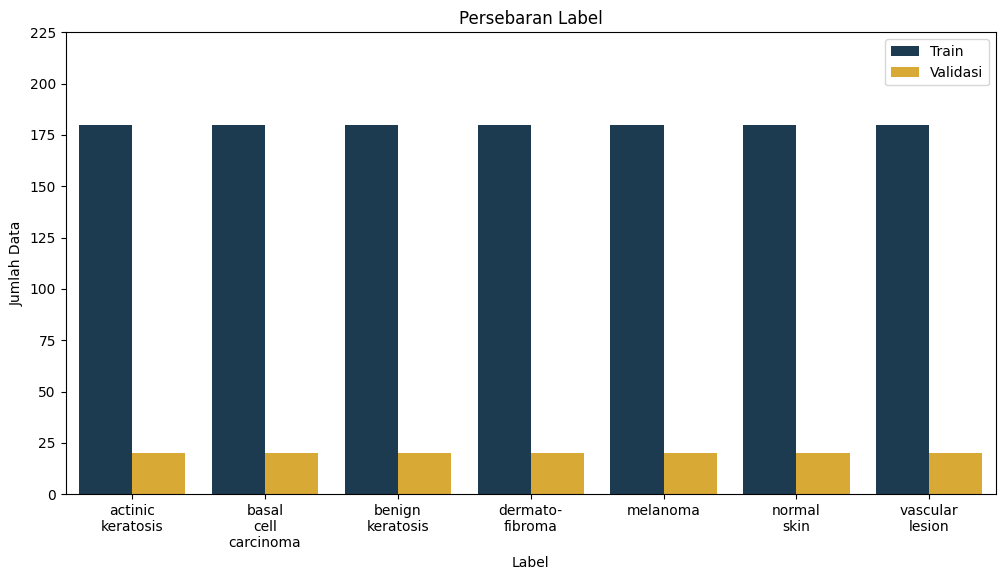

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Menghitung jumlah data per label untuk train dan test
train_counts = train_df['labels'].value_counts().sort_index()
test_counts = test_df['labels'].value_counts().sort_index()

# Menggabungkan data train dan test untuk membuat barplot
counts_df = pd.DataFrame({'Label': train_counts.index, 'Train': train_counts.values, 'Validasi': test_counts.values})
counts_df['Label'] = counts_df['Label'].replace('dermatofibroma', 'dermato-\nfibroma')

# Mengubah data menjadi format long
counts_df = counts_df.melt(id_vars='Label', var_name='Dataset', value_name='Jumlah Data')

# Membuat label panjang menjadi dua baris
counts_df['Label'] = counts_df['Label'].replace({
    'dermatofibrima': 'dermato-\nfibrima'
})

# Membuat barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Label', y='Jumlah Data', hue='Dataset', data=counts_df, palette=['#143d59', '#f4b41a'])

# Menambahkan judul dan label sumbu
plt.title('Persebaran Label')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')

# Mengatur batas sumbu y
plt.ylim(0, 225)

# Menampilkan label dalam dua baris jika panjang
labels = counts_df['Label'].unique()
plt.xticks(range(len(labels)), [label.replace(" ", "\n") for label in labels])

# Menghapus judul dari legend
plt.legend(loc='upper right')

# Menampilkan plot
plt.show()


> ### Train

In [6]:
# Generate data paths with labels
train_data_dir = '/kaggle/working/train'
filepaths = []
labels = []

# Path to folders
folds = os.listdir(train_data_dir)

# join path to folder and then path to each file, fyuhh
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)
# train_df = train_df[train_df['labels'] != "squamous cell carcinoma"]

In [7]:
train_df

,filepaths,labels
0,/kaggle/working/train/vascular lesion/ISIC_007...,vascular lesion
1,/kaggle/working/train/vascular lesion/ISIC_006...,vascular lesion
2,/kaggle/working/train/vascular lesion/ISIC_002...,vascular lesion
3,/kaggle/working/train/vascular lesion/ISIC_006...,vascular lesion
4,/kaggle/working/train/vascular lesion/ISIC_003...,vascular lesion
...,...,...
1255,/kaggle/working/train/normal skin/istockphoto-...,normal skin
1256,/kaggle/working/train/normal skin/istockphoto-...,normal skin
1257,/kaggle/working/train/normal skin/istockphoto-...,normal skin
1258,/kaggle/working/train/normal skin/95.jpg,normal skin


> ### Test

In [8]:
# like train process 
test_data_dir = '/kaggle/working/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)
# test_df = test_df[test_df['labels'] != "squamous cell carcinoma"]

In [9]:
test_df

,filepaths,labels
0,/kaggle/working/test/vascular lesion/ISIC_0061...,vascular lesion
1,/kaggle/working/test/vascular lesion/ISIC_0062...,vascular lesion
2,/kaggle/working/test/vascular lesion/ISIC_0072...,vascular lesion
3,/kaggle/working/test/vascular lesion/ISIC_0059...,vascular lesion
4,/kaggle/working/test/vascular lesion/ISIC_0067...,vascular lesion
...,...,...
135,/kaggle/working/test/normal skin/istockphoto-9...,normal skin
136,/kaggle/working/test/normal skin/istockphoto-1...,normal skin
137,/kaggle/working/test/normal skin/istockphoto-4...,normal skin
138,/kaggle/working/test/normal skin/istockphoto-6...,normal skin


> ## Processing

In [10]:
# resize image
batch_size = 28
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

train_gen = ImageDataGenerator(
                        rotation_range=40,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        rescale=1./255,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1.0/255.)

train_gen = train_gen.flow_from_dataframe(train_df, x_col= 'filepaths', y_col= 'labels', target_size = img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle = True, batch_size = batch_size)

test_gen = test_gen.flow_from_dataframe(test_df, x_col= 'filepaths', y_col= 'labels', target_size = img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle = False, batch_size = batch_size)

Found 1260 validated image filenames belonging to 7 classes.
Found 140 validated image filenames belonging to 7 classes.


> ## Samples Of The Data


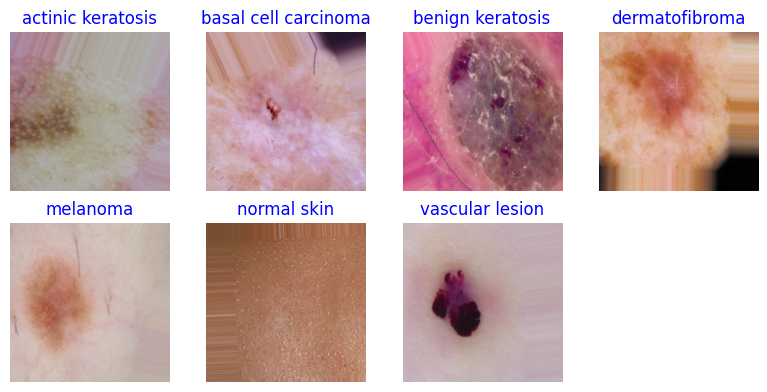

In [11]:
g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       

# Dictionary to store one image per class
class_images = {class_name: None for class_name in classes}
class_labels = {class_name: None for class_name in classes}

# Fetch batches until we have one image per class
while any(img is None for img in class_images.values()):
    images, labels = next(train_gen)
    for i in range(len(images)):
        index = np.argmax(labels[i])
        class_name = classes[index]
        if class_images[class_name] is None:
            class_images[class_name] = images[i]
            class_labels[class_name] = labels[i]
        # Break if we have found images for all classes
        if not any(img is None for img in class_images.values()):
            break

# Plot the images
plt.figure(figsize=(8, 4))

for i, class_name in enumerate(classes):
     plt.subplot(2, 4, i + 1)
     image = class_images[class_name]        
     plt.imshow(image)
     plt.title(class_name, color='blue', fontsize=12)
     plt.axis('off')

plt.tight_layout()
plt.show()


# Modelling

# 1. CNN (Baseline)


In [12]:
from tensorflow.keras.layers import MaxPooling2D
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

model1 = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
  
    Flatten(),
    
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model1.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.92):
      print("\nReached 92% accuracy so cancelling training!")
      self.model.stop_training = True

In [14]:
epochs = 100

steps_per_epoch = len(train_df) // batch_size
validation_steps = len(test_df) // batch_size

callback = myCallback()

history1 = model1.fit(x = train_gen, epochs = epochs, steps_per_epoch = steps_per_epoch, verbose = 1, 
                    validation_data = test_gen, validation_steps =  validation_steps, shuffle = False, callbacks = callback)

Epoch 1/100


I0000 00:00:1717262419.544016      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 [==============================] - 36s 549ms/step - loss: 2.0803 - accuracy: 0.1532 - val_loss: 1.9101 - val_accuracy: 0.2143
Epoch 2/100
45/45 [==============================] - 24s 539ms/step - loss: 1.9369 - accuracy: 0.1754 - val_loss: 1.9236 - val_accuracy: 0.2643
Epoch 3/100
45/45 [==============================] - 25s 543ms/step - loss: 1.9091 - accuracy: 0.1833 - val_loss: 1.9143 - val_accuracy: 0.1571
Epoch 4/100
45/45 [==============================] - 24s 537ms/step - loss: 1.8259 - accuracy: 0.2540 - val_loss: 1.7414 - val_accuracy: 0.2857
Epoch 5/100
45/45 [==============================] - 24s 539ms/step - loss: 1.7455 - accuracy: 0.2873 - val_loss: 1.6313 - val_accuracy: 0.3643
Epoch 6/100
45/45 [==============================] - 24s 540ms/step - loss: 1.6266 - accuracy: 0.3444 - val_loss: 1.4757 - val_accuracy: 0.4786
Epoch 7/100
45/45 [==============================] - 25s 546ms/step - loss: 1.5519 - accuracy: 0.4024 - val_loss: 1.4478 - val_accuracy: 0.4643
Epoc

In [15]:
# #Save the model
model1.save('Model1.h5')

> # Model Performance

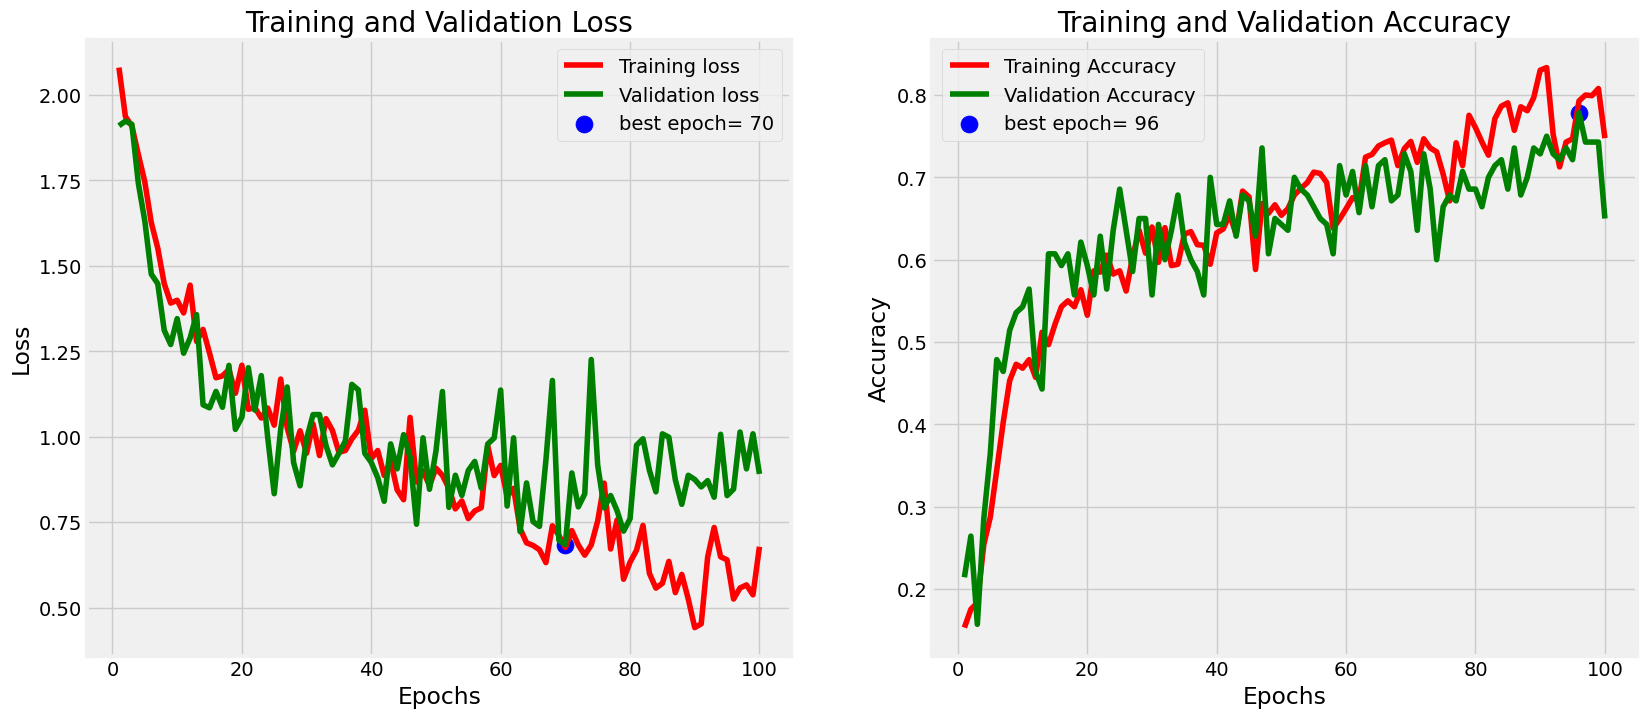

In [16]:
# Define needed variables
def f_history(history = history1):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

f_history(history1)

> ## Classification Report

In [17]:
g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       

preds = model1.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                      precision    recall  f1-score   support

   actinic keratosis       0.58      0.70      0.64        20
basal cell carcinoma       0.59      0.50      0.54        20
    benign keratosis       0.67      0.60      0.63        20
      dermatofibroma       0.38      0.30      0.33        20
            melanoma       0.64      0.80      0.71        20
         normal skin       0.91      1.00      0.95        20
     vascular lesion       0.72      0.65      0.68        20

            accuracy                           0.65       140
           macro avg       0.64      0.65      0.64       140
        weighted avg       0.64      0.65      0.64       140



> ## Confusion Matrics 

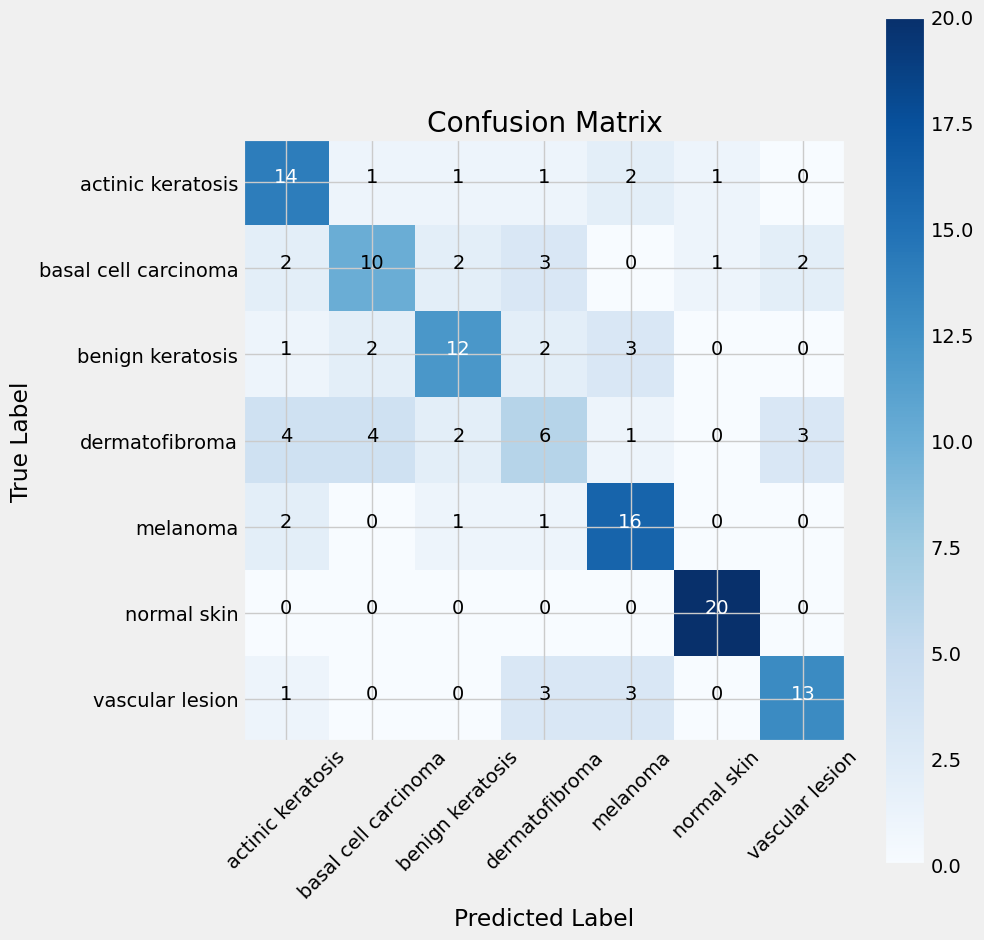

In [18]:
import itertools
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

    # Confusion matrix
def f_cm(y_pred = y_pred):
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()

f_cm(y_pred)

## Transfer Learning

In [19]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, DenseNet201, ResNet152V2

### 0. ALL MODEL

In [20]:
# import pandas as pd
# from tensorflow.keras.applications import (
#     MobileNetV2, InceptionV3, VGG16, VGG19, ResNet50, InceptionResNetV2,
#     DenseNet121, DenseNet169, DenseNet201,
#     NASNetLarge, NASNetMobile,
#     EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7,
#     Xception, MobileNet,
#     ResNet101, ResNet152,
#     ResNet101V2, ResNet152V2,
#     ResNet50V2
# )
# from tensorflow.keras import layers, Model
# from tensorflow.keras.optimizers import Adamax
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# def create_and_train_model(base_model_class, input_shape, class_count, epochs, train_gen, test_gen, steps_per_epoch, validation_steps):
#     base_model = base_model_class(input_shape = input_shape, include_top = False)#, weights='imagenet') #
#     base_model.trainable = False

#     last_layer = base_model.layers[-1]
#     last_output = last_layer.output

#     x = layers.Flatten()(last_output)
#     x = layers.Dense(512, activation='relu')(x)
#     x = layers.Dropout(0.3)(x)
#     x = layers.Dense(class_count, activation='softmax')(x)

#     model = Model(inputs=base_model.input, outputs=x)
#     model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
#     history = model.fit(
#         x=train_gen,
#         epochs=epochs,
#         steps_per_epoch=steps_per_epoch,
#         validation_data=test_gen,
#         validation_steps=validation_steps,
#         shuffle = False,
#         verbose = 1  # Set to 1 to see the progress
#     )

#     train_accuracy = history.history['accuracy'][-1]
#     val_accuracy = history.history['val_accuracy'][-1]
#     max_train_accuracy = max(history.history['accuracy'])
#     max_val_accuracy = max(history.history['val_accuracy'])

#     return train_accuracy, val_accuracy, max_train_accuracy, max_val_accuracy, history

# def evaluate_models(models, input_shape, class_count, epochs, train_gen, test_gen, steps_per_epoch, validation_steps):
#     results = []

#     for model_name, model_class in models.items():
#         print(f"Evaluating model: {model_name}")
#         train_acc, val_acc, max_train_acc, max_val_acc, history = create_and_train_model(
#             model_class, input_shape, class_count, epochs, train_gen, test_gen, steps_per_epoch, validation_steps
#         )
        
#         results.append({
#             'Model': model_name,
#             'Train Accuracy': train_acc,
#             'Validation Accuracy': val_acc,
#             'Max Train Accuracy': max_train_acc,
#             'Max Validation Accuracy': max_val_acc
#         })
        
#         f_history(history)

#     return pd.DataFrame(results)

# # Dictionary of model classes
# model_classes = {
#     'MobileNetV2': MobileNetV2,
#     'InceptionV3': InceptionV3,
# #     'VGG16': VGG16,
# #     'VGG19': VGG19,
# #     'ResNet50': ResNet50,
#     'InceptionResNetV2': InceptionResNetV2,
# #     'DenseNet121': DenseNet121,
# #     'DenseNet169': DenseNet169,
#     'DenseNet201': DenseNet201,
#     'NASNetLarge': NASNetLarge,
#     'NASNetMobile': NASNetMobile,
# #     'EfficientNetB0': EfficientNetB0,
# #     'EfficientNetB1': EfficientNetB1,
# #     'EfficientNetB2': EfficientNetB2,
# #     'EfficientNetB3': EfficientNetB3,
# #     'EfficientNetB4': EfficientNetB4,
# #     'EfficientNetB5': EfficientNetB5,
# #     'EfficientNetB6': EfficientNetB6,
# #     'EfficientNetB7': EfficientNetB7,
#     'Xception': Xception,
# #     'MobileNet': MobileNet,
# #     'ResNet101': ResNet101,
# #     'ResNet152': ResNet152,
#     'ResNet101V2': ResNet101V2,
#     'ResNet152V2': ResNet152V2,
# #     'ResNet50V2': ResNet50V2
# }

# # Example usage
# input_shape = (224, 224, 3)
# class_count = len(list(train_gen.class_indices.keys()))  # Replace with actual number of classes
# epochs = 25
# steps_per_epoch = len(train_df) // batch_size
# validation_steps = len(test_df) // batch_size

# results_df = evaluate_models(model_classes, input_shape, class_count, epochs, train_gen, test_gen, steps_per_epoch, validation_steps)
# print(results_df)

In [21]:
# results_df.sort_values('Validation Accuracy', ascending = False).reset_index(drop = True)

# 2. ResNet152 V2

In [22]:
rn152v2_model = ResNet152V2(input_shape = (img_size[0], img_size[1], 3), include_top = False)
rn152v2_model.trainable = True

last_layer = rn152v2_model.get_layer('conv5_block1_preact_bn')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# last_output = rn152v2_model.output
# print('last layer output shape: ', rn152v2_model.output_shape)

234545216/234545216 [==============================] - 1s 0us/step
last layer output shape:  (None, 7, 7, 1024)


In [23]:
from tensorflow.keras import layers
from tensorflow.keras import Model

class_count = len(list(train_gen.class_indices.keys()))

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)                  
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.3)(x)                  
x = layers.Dense(class_count, activation='softmax')(x)           

model2 = Model(rn152v2_model.input, x) 

model2.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [24]:
epochs = 100   

steps_per_epoch = len(train_df) // batch_size
validation_steps = len(test_df) // batch_size

history2 = model2.fit(x = train_gen, epochs = epochs, steps_per_epoch = steps_per_epoch, verbose = 1, 
                    validation_data = test_gen, validation_steps =  validation_steps, shuffle = False, callbacks = callback)

Epoch 1/100
45/45 [==============================] - 97s 604ms/step - loss: 59.3058 - accuracy: 0.2571 - val_loss: 2492.3838 - val_accuracy: 0.2286
Epoch 2/100
45/45 [==============================] - 25s 549ms/step - loss: 2.9643 - accuracy: 0.3960 - val_loss: 77.2846 - val_accuracy: 0.2786
Epoch 3/100
45/45 [==============================] - 25s 550ms/step - loss: 1.4649 - accuracy: 0.4405 - val_loss: 14.7683 - val_accuracy: 0.3286
Epoch 4/100
45/45 [==============================] - 25s 548ms/step - loss: 1.3363 - accuracy: 0.4714 - val_loss: 2.1901 - val_accuracy: 0.4643
Epoch 5/100
45/45 [==============================] - 25s 551ms/step - loss: 1.2835 - accuracy: 0.4865 - val_loss: 1.7009 - val_accuracy: 0.4357
Epoch 6/100
45/45 [==============================] - 25s 537ms/step - loss: 1.2638 - accuracy: 0.5079 - val_loss: 1.2453 - val_accuracy: 0.5929
Epoch 7/100
45/45 [==============================] - 25s 548ms/step - loss: 1.1521 - accuracy: 0.5397 - val_loss: 1.1411 - val_acc

In [25]:
# #Save the model
model2.save('Model2.h5')

> # Model Performance

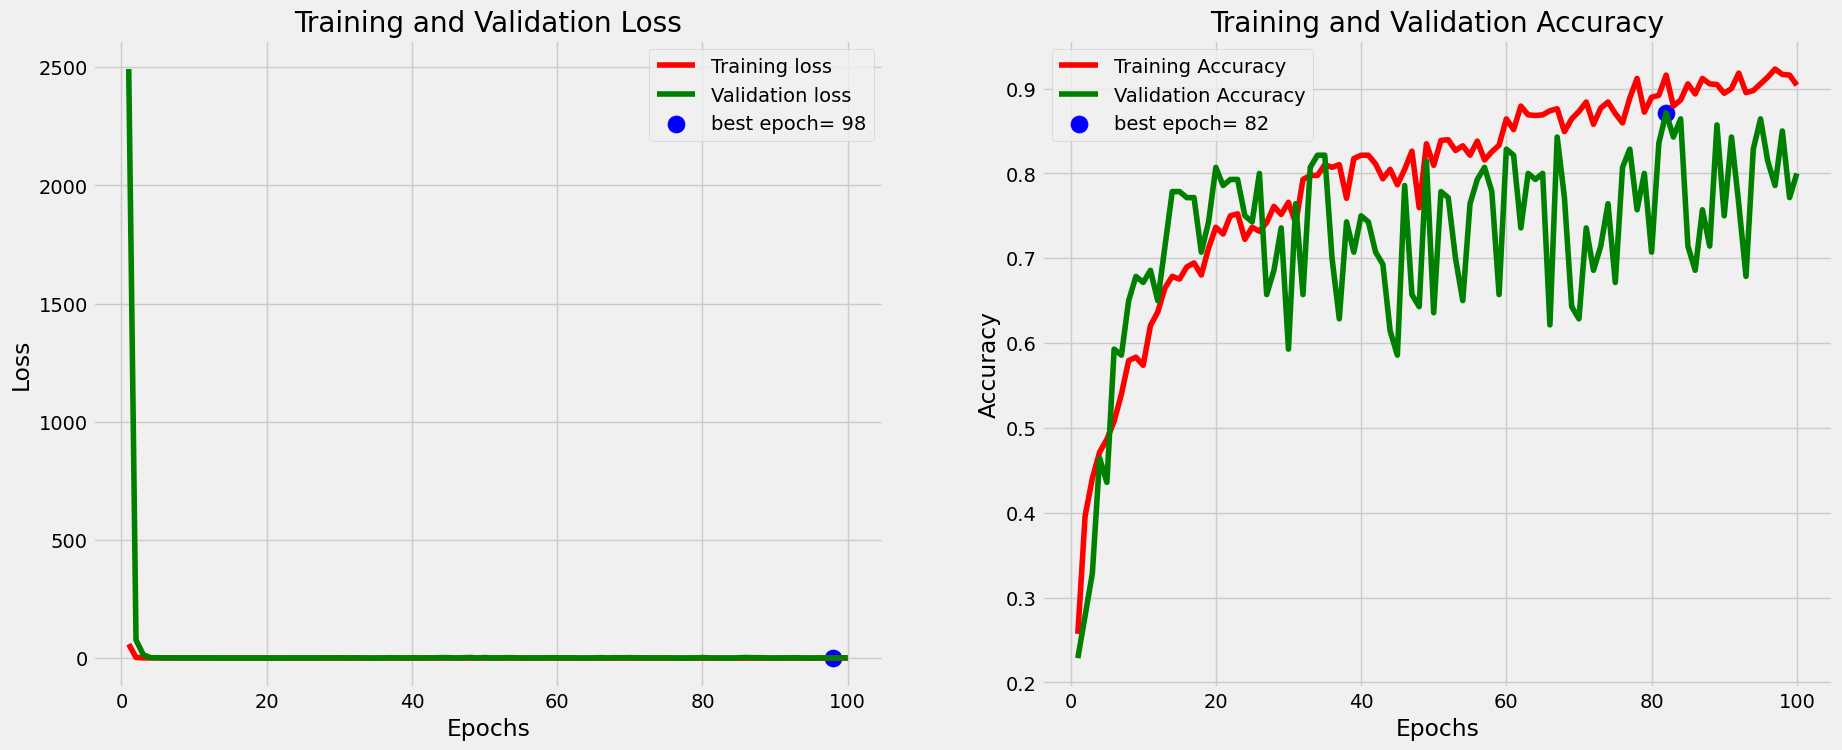

In [26]:
f_history(history2)

> ## Classification Report

In [27]:
preds = model2.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                      precision    recall  f1-score   support

   actinic keratosis       0.89      0.40      0.55        20
basal cell carcinoma       0.85      0.85      0.85        20
    benign keratosis       0.88      0.70      0.78        20
      dermatofibroma       1.00      0.70      0.82        20
            melanoma       0.59      0.95      0.73        20
         normal skin       0.71      1.00      0.83        20
     vascular lesion       0.95      1.00      0.98        20

            accuracy                           0.80       140
           macro avg       0.84      0.80      0.79       140
        weighted avg       0.84      0.80      0.79       140



> ## Confussion Matrics

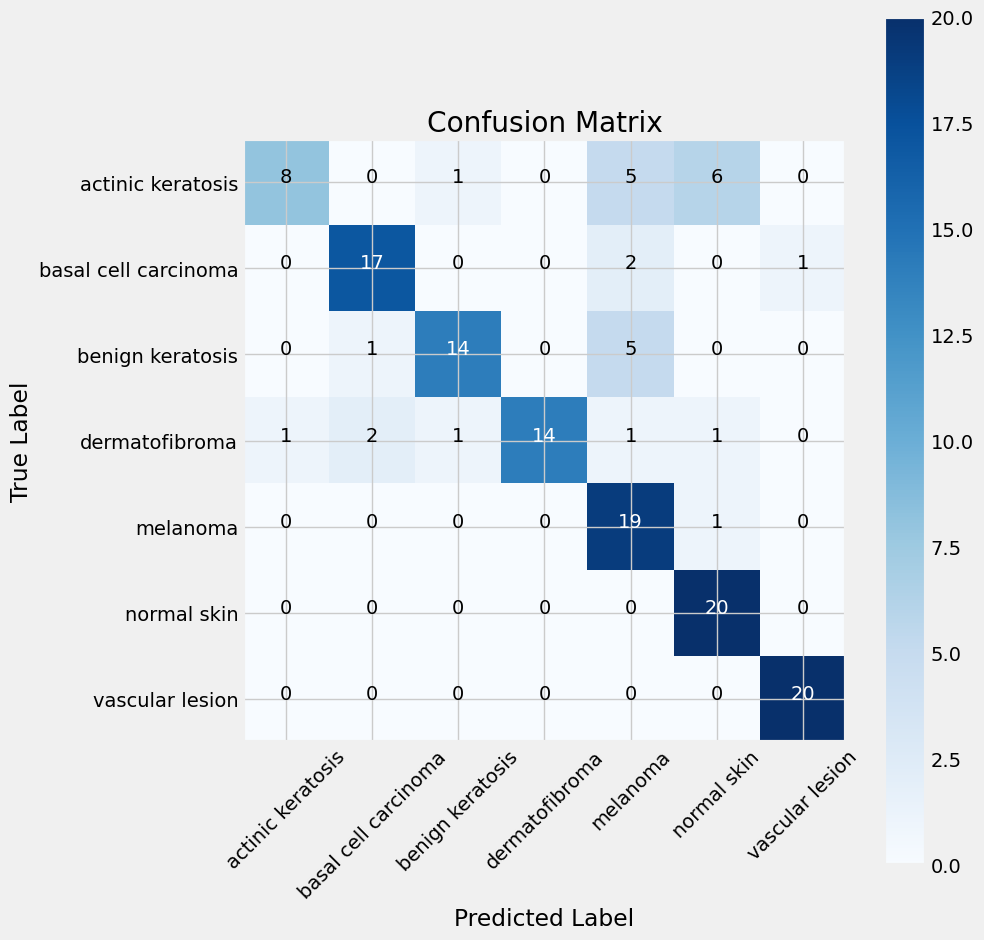

In [28]:
f_cm(y_pred)

# 3. Inception V3

In [29]:
incept_model=InceptionV3(input_shape=(img_size[0], img_size[1], 3),include_top=False)
incept_model.trainable = True

last_layer = incept_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# last_output = incept_model.output
# print('last layer output shape: ', incept_model.output_shape)

87910968/87910968 [==============================] - 0s 0us/step
last layer output shape:  (None, 12, 12, 768)


In [30]:
from tensorflow.keras import layers
from tensorflow.keras import Model

class_count = len(list(train_gen.class_indices.keys()))

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# x = layers.Dropout(0.4)(x)    
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)                  
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.4)(x)                  
x = layers.Dense(class_count, activation='softmax')(x)           

model3 = Model(incept_model.input, x) 

model3.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d_7[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0]

In [31]:
epochs = 100   

steps_per_epoch = len(train_df) // batch_size
validation_steps = len(test_df) // batch_size

history3 = model3.fit(x = train_gen, epochs = epochs, steps_per_epoch = steps_per_epoch, verbose = 1, 
                    validation_data = test_gen, validation_steps =  validation_steps, shuffle = False)#, callbacks = callback)

Epoch 1/100
45/45 [==============================] - 49s 558ms/step - loss: 2.1998 - accuracy: 0.2698 - val_loss: 1.7376 - val_accuracy: 0.3000
Epoch 2/100
45/45 [==============================] - 24s 539ms/step - loss: 1.3072 - accuracy: 0.4810 - val_loss: 1.4118 - val_accuracy: 0.4714
Epoch 3/100
45/45 [==============================] - 24s 542ms/step - loss: 1.0294 - accuracy: 0.6294 - val_loss: 1.5169 - val_accuracy: 0.4429
Epoch 4/100
45/45 [==============================] - 24s 539ms/step - loss: 0.7684 - accuracy: 0.7500 - val_loss: 0.7710 - val_accuracy: 0.7143
Epoch 5/100
45/45 [==============================] - 24s 541ms/step - loss: 0.6630 - accuracy: 0.7746 - val_loss: 0.7975 - val_accuracy: 0.7357
Epoch 6/100
45/45 [==============================] - 24s 542ms/step - loss: 0.5361 - accuracy: 0.8095 - val_loss: 1.0159 - val_accuracy: 0.7143
Epoch 7/100
45/45 [==============================] - 24s 540ms/step - loss: 0.4329 - accuracy: 0.8460 - val_loss: 0.4243 - val_accuracy:

In [32]:
# #Save the model
model3.save('Model3.h5')

> # Model Performance

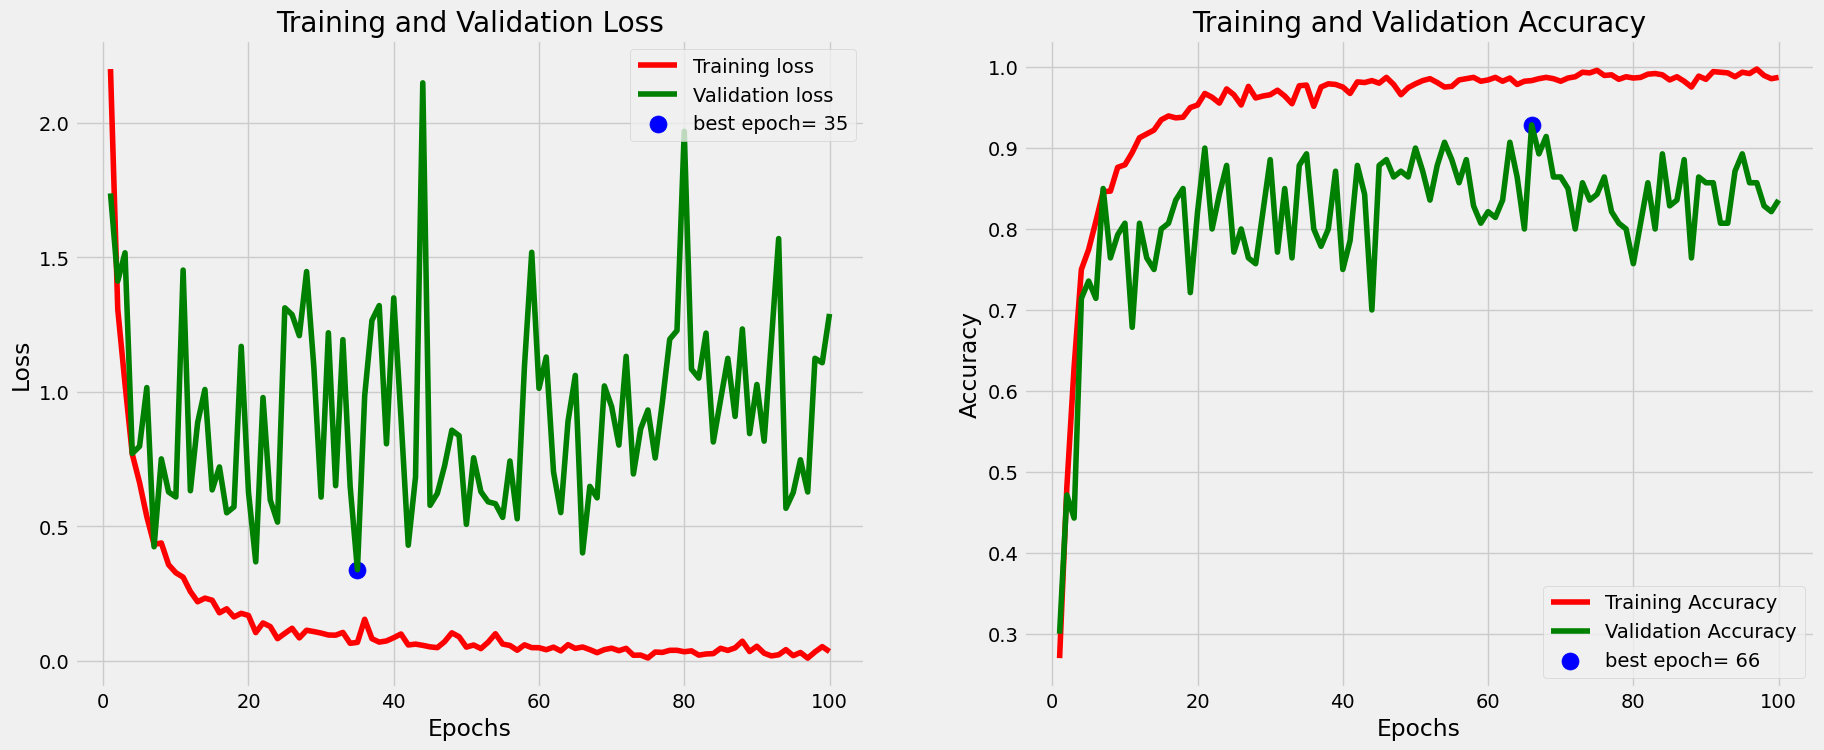

In [33]:
f_history(history3)

> ## Classification Report

In [34]:
# Classification report
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                      precision    recall  f1-score   support

   actinic keratosis       1.00      0.40      0.57        20
basal cell carcinoma       0.86      0.90      0.88        20
    benign keratosis       0.63      0.95      0.76        20
      dermatofibroma       0.82      0.90      0.86        20
            melanoma       0.80      0.80      0.80        20
         normal skin       1.00      1.00      1.00        20
     vascular lesion       0.95      0.90      0.92        20

            accuracy                           0.84       140
           macro avg       0.87      0.84      0.83       140
        weighted avg       0.87      0.84      0.83       140



> ## Confussion Matrics

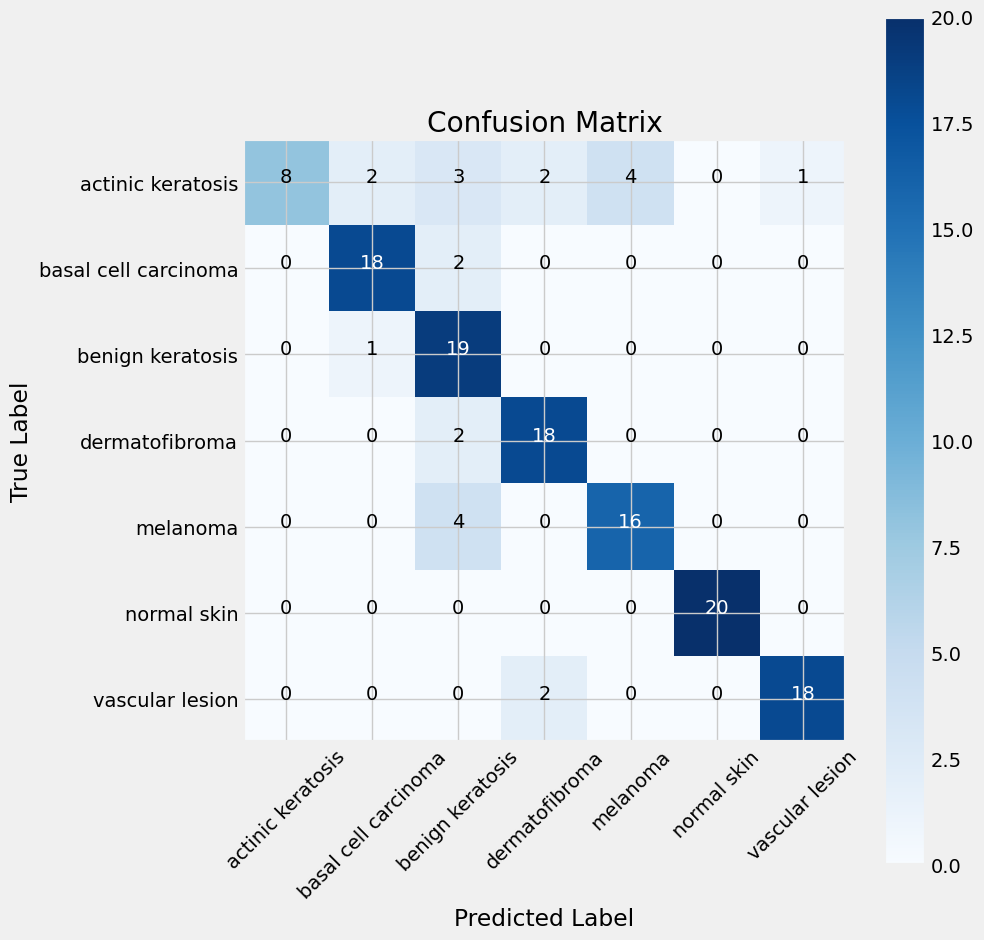

In [35]:
f_cm(y_pred)

# 4. Densenet201

In [36]:
dn201_model = DenseNet201(input_shape=(224, 224, 3),include_top = False)
dn201_model.trainable = True

last_layer = dn201_model.get_layer('conv5_block1_0_bn')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

74836368/74836368 [==============================] - 0s 0us/step
last layer output shape:  (None, 7, 7, 896)


In [37]:
from tensorflow.keras import layers
from tensorflow.keras import Model

class_count = len(list(train_gen.class_indices.keys()))

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# x = layers.Dropout(0.3)(x)                  
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)                  
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.3)(x)                  
x = layers.Dense(class_count, activation='softmax')(x)           

model4 = Model(dn201_model.input, x) 

model4.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [38]:
epochs = 100

steps_per_epoch = len(train_df) // batch_size
validation_steps = len(test_df) // batch_size

callback = myCallback()

history4 = model4.fit(x = train_gen, epochs = epochs, steps_per_epoch = steps_per_epoch, verbose = 1, 
                    validation_data = test_gen, validation_steps =  validation_steps, shuffle = False, callbacks = callback)

Epoch 1/100
45/45 [==============================] - 98s 593ms/step - loss: 1.1788 - accuracy: 0.5873 - val_loss: 2.4088 - val_accuracy: 0.5429
Epoch 2/100
45/45 [==============================] - 25s 552ms/step - loss: 0.7421 - accuracy: 0.7325 - val_loss: 7.0648 - val_accuracy: 0.3786
Epoch 3/100
45/45 [==============================] - 25s 558ms/step - loss: 0.5891 - accuracy: 0.7849 - val_loss: 7.0750 - val_accuracy: 0.3714
Epoch 4/100
45/45 [==============================] - 25s 561ms/step - loss: 0.4879 - accuracy: 0.8310 - val_loss: 2.0848 - val_accuracy: 0.4643
Epoch 5/100
45/45 [==============================] - 25s 554ms/step - loss: 0.4628 - accuracy: 0.8492 - val_loss: 1.4441 - val_accuracy: 0.5357
Epoch 6/100
45/45 [==============================] - 25s 557ms/step - loss: 0.3484 - accuracy: 0.8833 - val_loss: 2.7953 - val_accuracy: 0.5000
Epoch 7/100
45/45 [==============================] - 25s 556ms/step - loss: 0.3534 - accuracy: 0.8690 - val_loss: 2.1032 - val_accuracy:

In [39]:
# #Save the model
model4.save('Model4.h5')

> # Model Performance

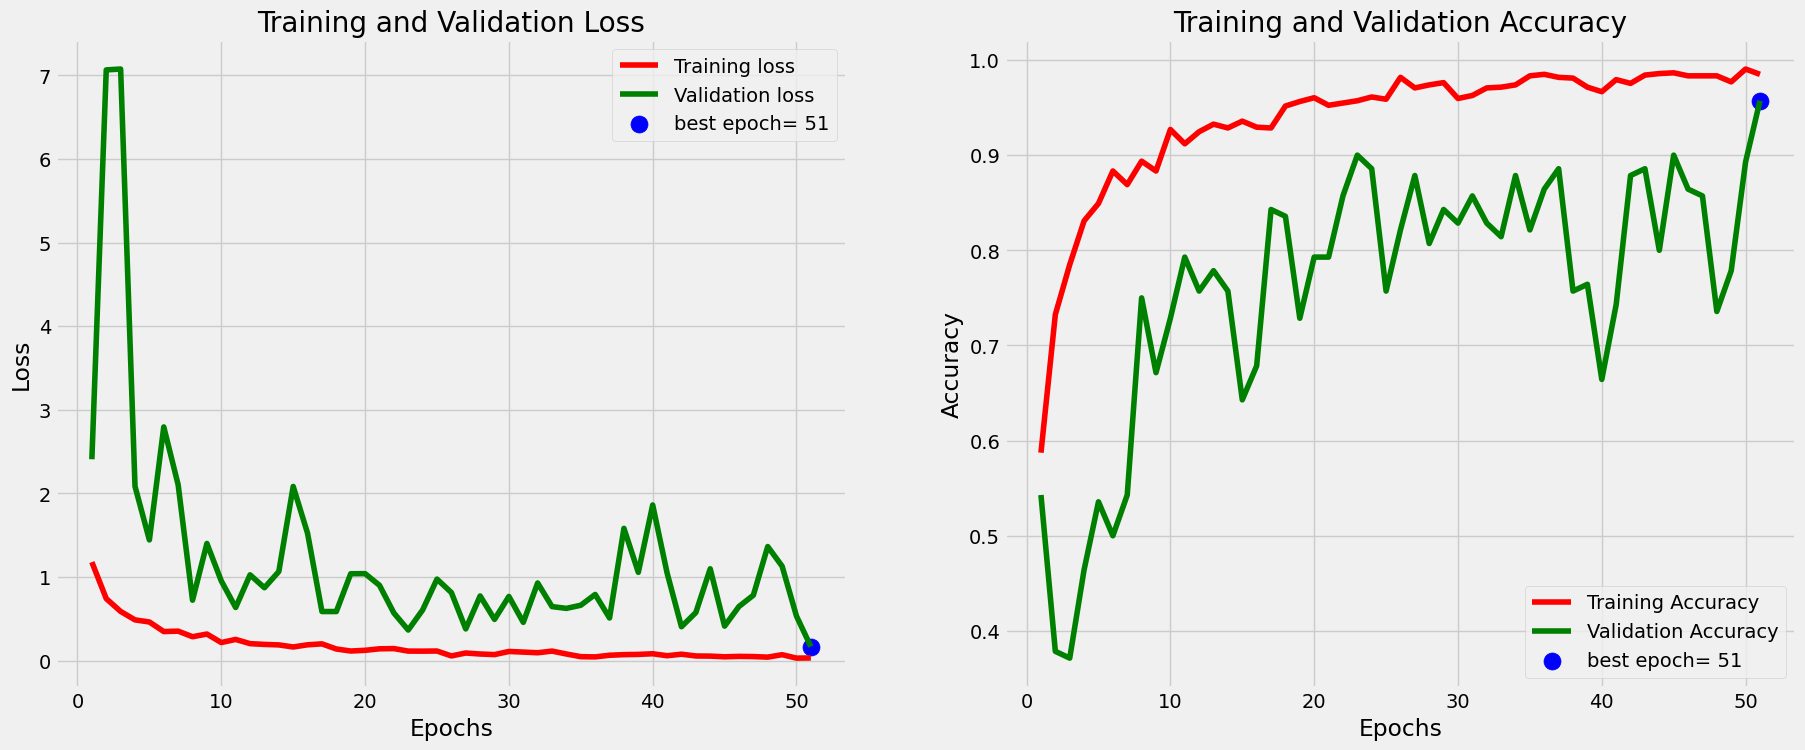

In [40]:
f_history(history4)

> ## Classification Report

In [41]:
# Classification report
preds = model4.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                      precision    recall  f1-score   support

   actinic keratosis       1.00      1.00      1.00        20
basal cell carcinoma       1.00      0.95      0.97        20
    benign keratosis       0.89      0.85      0.87        20
      dermatofibroma       0.91      1.00      0.95        20
            melanoma       0.90      0.95      0.93        20
         normal skin       1.00      1.00      1.00        20
     vascular lesion       1.00      0.95      0.97        20

            accuracy                           0.96       140
           macro avg       0.96      0.96      0.96       140
        weighted avg       0.96      0.96      0.96       140



> ## Confussion Matrics

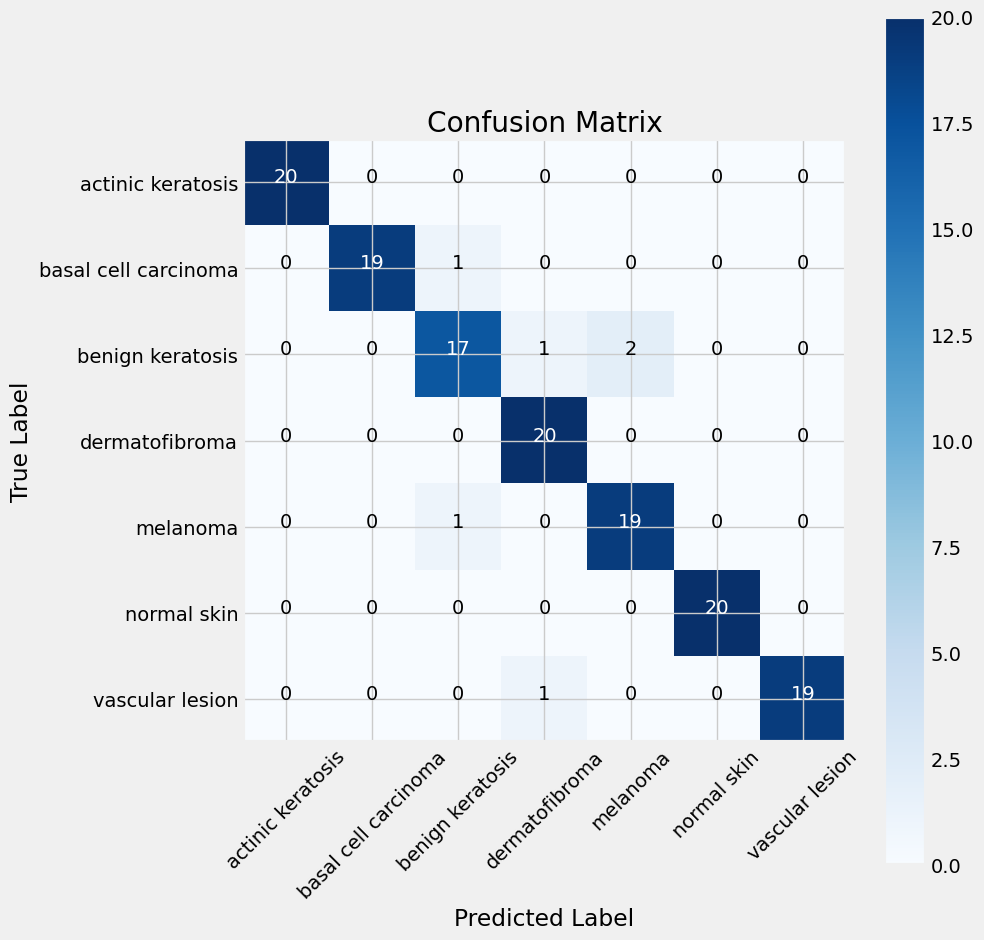

In [42]:
f_cm(y_pred)

# Save model

In [43]:
# loaded_model1 = tf.keras.models.load_model('/kaggle/working/Model1.h5', compile=False)
# %cd /kaggle/working

In [44]:
# from IPython.display import FileLink -> FileLink(r'Model1.h5')

In [45]:
# #Save the model
# model.save('Model.h5')

**rediction using loaded_model**

In [46]:
# loaded_model = tf.keras.models.load_model('/kaggle/working/Model.h5', compile=False)
# loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [47]:
# image_path = ''
# image = Image.open(image_path)

# # Preprocess the image
# img = image.resize((224, 224))
# img_array = tf.keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)

# # Make predictions
# predictions = loaded_model.predict(img_array)
# class_labels = classes
# score = tf.nn.softmax(predictions[0])
# print(f"{class_labels[tf.argmax(score)]}")

In [48]:
# predictions